In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.random.seed(7)
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

In [3]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

ford

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.959860,0.969352,0.974160,0.982862,0.966201,0.049889
2015-05-18,0.977312,0.982487,0.989664,0.991431,0.975584,0.052362
2015-05-19,0.987784,0.981611,0.989664,0.984576,0.968078,0.032961
2015-05-20,0.983421,0.975482,0.973299,0.967438,0.949312,0.065305
2015-05-21,0.960733,0.974606,0.973299,0.985433,0.969016,0.072315
...,...,...,...,...,...,...
2020-05-08,0.060209,0.072680,0.085271,0.105398,0.149157,0.417663
2020-05-11,0.079407,0.067426,0.093885,0.095116,0.134605,0.302773
2020-05-12,0.076789,0.070053,0.086994,0.083119,0.117628,0.282113


In [4]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
#print(build_data(0,1,200))

In [5]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,2):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
time taken for execution : 484.06481409072876 seconds 
Mean Validation loss= 0.00989674
[0.0100298, 0.00976367]


# 2. Dow Jones Index:

In [6]:
#Convert Date Format:
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

#merge values:
ford_dates = list(ford.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(ford_dates))
ford["dow"] = mean_dow
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in dow_dates:
        ford["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
ford

198.285659767141 1259


,Open,High,Low,Close,Adj Close,Volume,dow
Date,,,,,,,
2015-05-15,0.959860,0.969352,0.974160,0.982862,0.966201,0.049889,209.91
2015-05-18,0.977312,0.982487,0.989664,0.991431,0.975584,0.052362,212.63
2015-05-19,0.987784,0.981611,0.989664,0.984576,0.968078,0.032961,213.62
2015-05-20,0.983421,0.975482,0.973299,0.967438,0.949312,0.065305,213.01
2015-05-21,0.960733,0.974606,0.973299,0.985433,0.969016,0.072315,211.42
...,...,...,...,...,...,...,...
2020-05-08,0.060209,0.072680,0.085271,0.105398,0.149157,0.417663,237.39
2020-05-11,0.079407,0.067426,0.093885,0.095116,0.134605,0.302773,244.15
2020-05-12,0.076789,0.070053,0.086994,0.083119,0.117628,0.282113,244.85


In [8]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [9]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 734.7545502185822 seconds 
Mean Validation loss= 0.00996383
[0.01038226, 0.0099692, 0.00954002]


# 3. FTSE Index:

In [10]:
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    #print(year+'-'+month+'-'+day)
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)

#merge values:
ford_dates = list(ford.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
print(mean_ftse,len(ford_dates))
ford["ftse"] = mean_ftse
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in ftse_dates:
        ford["ftse"][row_num] = mean((ftse['newOpen'][ftse['FormatDate']==date]))
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6982.075098814229 1259


,Open,High,Low,Close,Adj Close,Volume,ftse
Date,,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700,6973.000000
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900,6960.000000
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300,6968.000000
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500,6995.000000
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000,7007.000000
...,...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800,6982.075099
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900,5936.000000
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200,5939.000000


In [12]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [13]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 745.053542137146 seconds 
Mean Validation loss= 0.00988404
[0.01030045, 0.00993009, 0.00942157]


# 4. S&P Global Oil Index:

In [14]:
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)

#merge values:
ford_dates = list(ford.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
#print(mean_oil,len(ford_dates))
ford["oil"] = mean_oil
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in oil_dates:
        ford["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,oil
Date,,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700,1956.93
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900,1948.25
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300,1917.52
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500,1916.57
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000,1936.78
...,...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800,1082.50
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900,1071.49
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200,1062.24


In [15]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #S&P global Oil:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [16]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 748.60382604599 seconds 
Mean Validation loss= 0.01012067
[0.01068894, 0.00990486, 0.00976821]


# 5. S&P1000 Index:

In [30]:
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)

#merge values:
ford_dates = list(ford.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
#print(mean_sp,len(ford_dates))
ford["S&P1000"] = mean_sp
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in sp1000_dates:
        ford["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))

del ford['Adj Close']
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,S&P1000
Date,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,18937700,8627.79
2015-05-18,15.47,15.64,15.45,15.58,19491900,8701.63
2015-05-19,15.59,15.63,15.45,15.50,15145300,8689.52
2015-05-20,15.54,15.56,15.26,15.30,22391500,8692.93
2015-05-21,15.28,15.55,15.26,15.51,23962000,8697.50
...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,101333800,9409.29
2020-05-11,5.18,5.19,5.05,5.12,75593900,9309.29
2020-05-12,5.15,5.22,4.97,4.98,70965200,8976.31


In [31]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #s&p 1000:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [33]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 745.2173080444336 seconds 
Mean Validation loss= 0.01038884
[0.01047806, 0.01048431, 0.01020414]


# 6. Crude Oil Prices:

In [21]:
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)

#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)

#merge values:
ford_dates = list(ford.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
print(mean_cop,len(ford_dates))
ford["CrudeOil"] = mean_cop
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in cr_oil_dates:
        ford["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))
    
ford

52.015504169825626 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,CrudeOil
Date,,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700,59.69
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900,59.43
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300,57.26
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500,58.98
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000,60.72
...,...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800,24.74
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900,24.14
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200,25.78


In [22]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [23]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 735.2732820510864 seconds 
Mean Validation loss= 0.00997574
[0.01019364, 0.00997991, 0.00975367]


# 7. Dow Jones Oil & Gas Supersector Titans Index

In [24]:
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)

#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)

#merge values:
ford_dates = list(ford.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
print(mean_top,len(ford_dates))
ford["TitanOil"] = mean_top
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in titan_oil_dates:
        ford["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
ford

394.1362162162162 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,TitanOil
Date,,,,,,,
2015-05-15,15.27,15.49,15.27,15.48,11.977631,18937700,445.40
2015-05-18,15.47,15.64,15.45,15.58,12.055005,19491900,443.20
2015-05-19,15.59,15.63,15.45,15.50,11.993106,15145300,437.01
2015-05-20,15.54,15.56,15.26,15.30,11.838357,22391500,437.22
2015-05-21,15.28,15.55,15.26,15.51,12.000844,23962000,441.62
...,...,...,...,...,...,...,...
2020-05-08,4.96,5.25,4.95,5.24,5.240000,101333800,267.26
2020-05-11,5.18,5.19,5.05,5.12,5.120000,75593900,265.18
2020-05-12,5.15,5.22,4.97,4.98,4.980000,70965200,262.17


In [25]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [26]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 745.7096898555756 seconds 
Mean Validation loss= 0.00996023
[0.010205, 0.00986709, 0.00980859]


# 8. Car Sales Data:

In [27]:
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
ford_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/fordsales.csv', header=0, index_col=None)

#merge values:
ford_dates = list(ford.index)
sales_dates = list(ford_sales['Month'])
ford["sales"] = 0

for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num][0:7] 
    
    if date in sales_dates:
        ford["sales"][row_num] = ford_sales['Sales'][ford_sales['Month']==date]
        
print(ford)

             Open   High    Low  Close  Adj Close     Volume   sales
Date                                                                
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  250077
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  250077
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  250077
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  250077
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  250077
...           ...    ...    ...    ...        ...        ...     ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  145484
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  145484
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  145484
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  145484
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  145484

[1259 rows x 7 columns]


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [28]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sales = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Sales:
    fit = scaler_sales.fit(np.array(data['sales']).reshape(-1, 1))
    data['sales'] =scaler_sales.transform(np.array(data['sales']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = ford
dataframe_ford = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [29]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(3,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat)
            actual_high.append(y_test)
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
print(val_loss)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 745.3683149814606 seconds 
Mean Validation loss= 0.01009188
[0.01083302, 0.00991155, 0.00953107]


In [49]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

0.010388836666666667

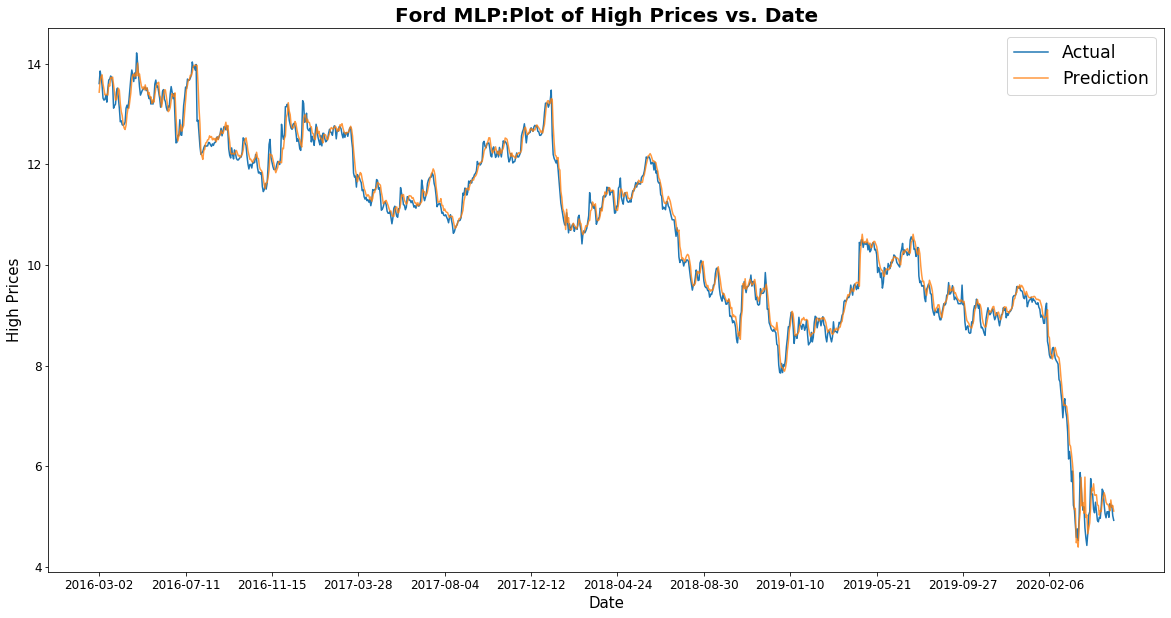

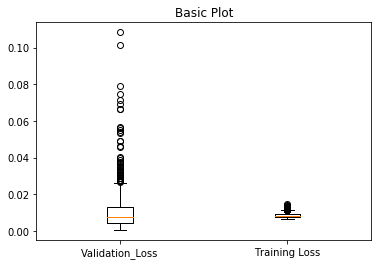

In [55]:
def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))
title_str = 'Ford MLP:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)



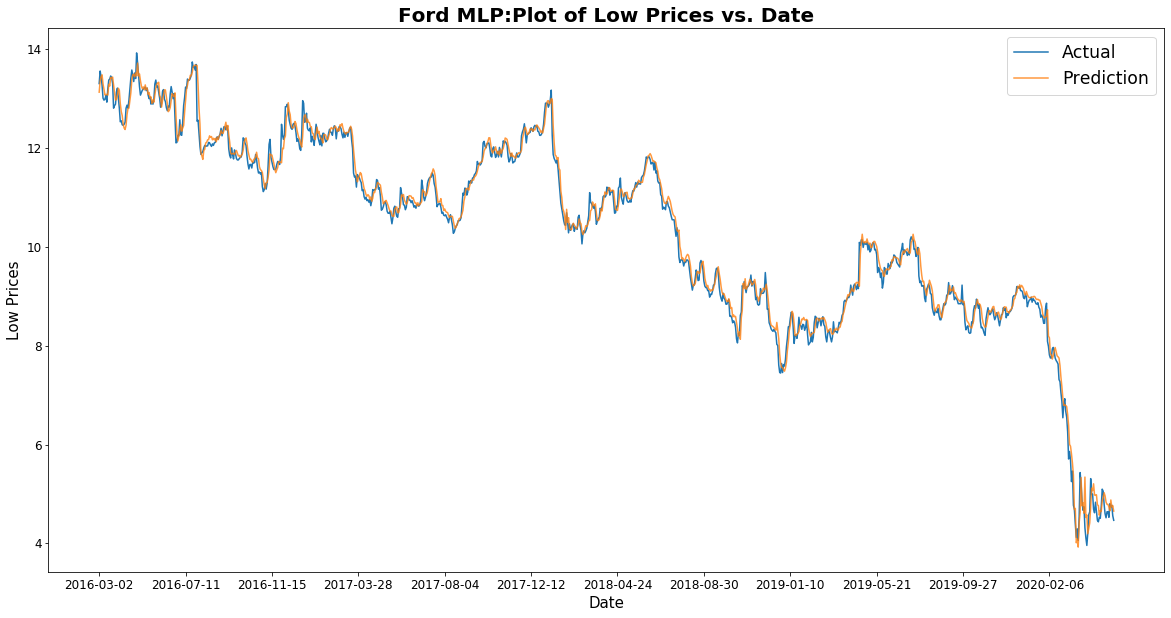

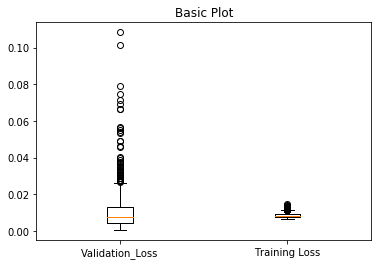

In [56]:
title_str = 'Ford MLP:Plot of Low Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_low,predicted_low ,np.array(predicted_dates),title_str,y_label )

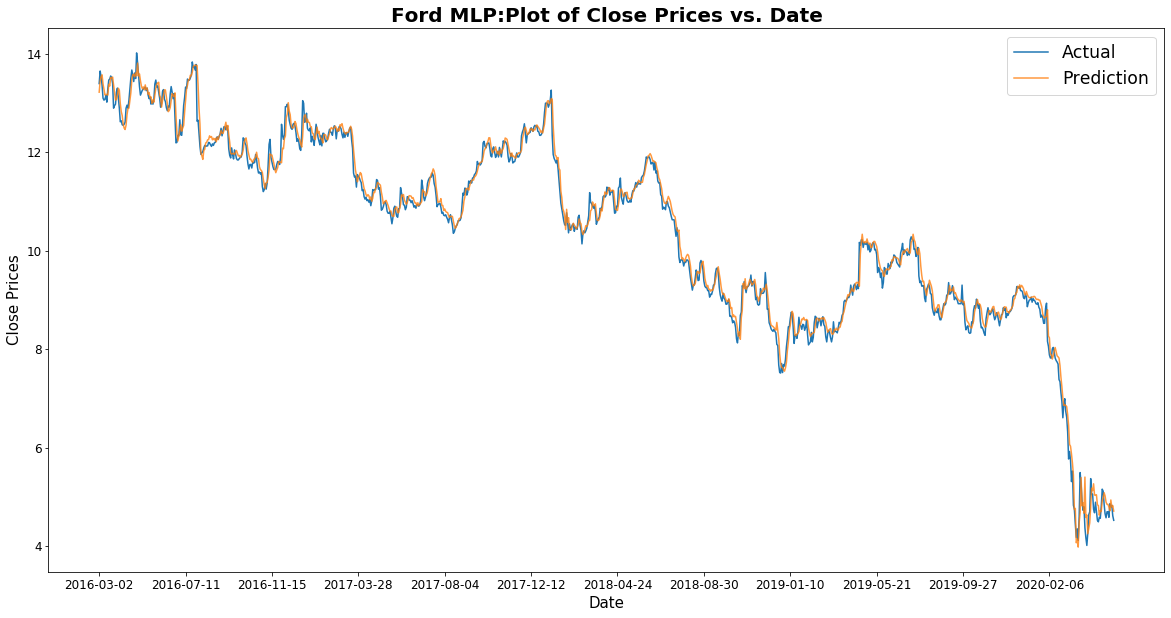

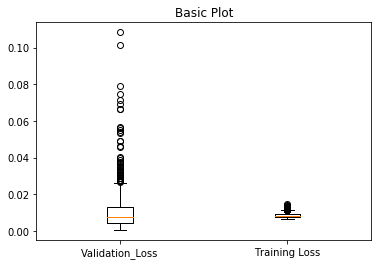

In [57]:
c

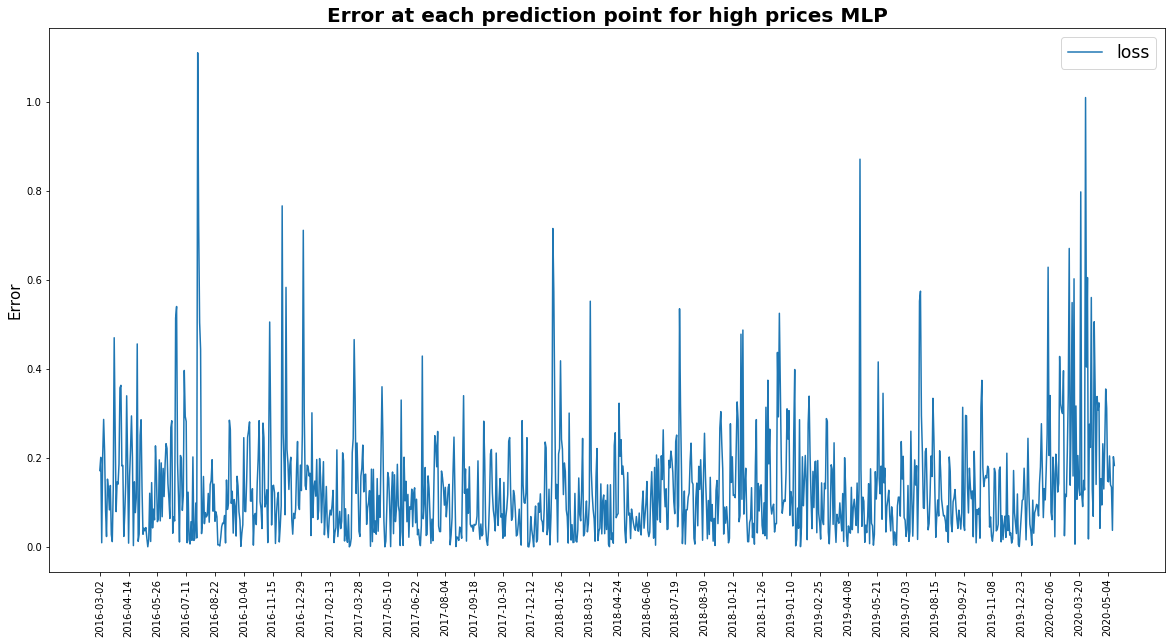

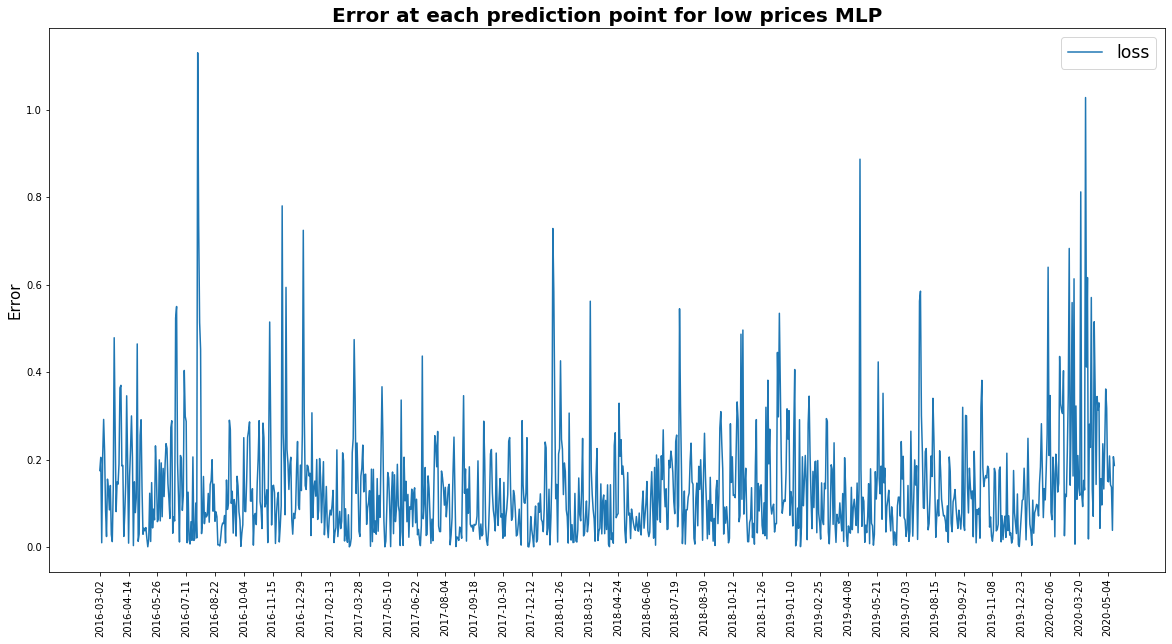

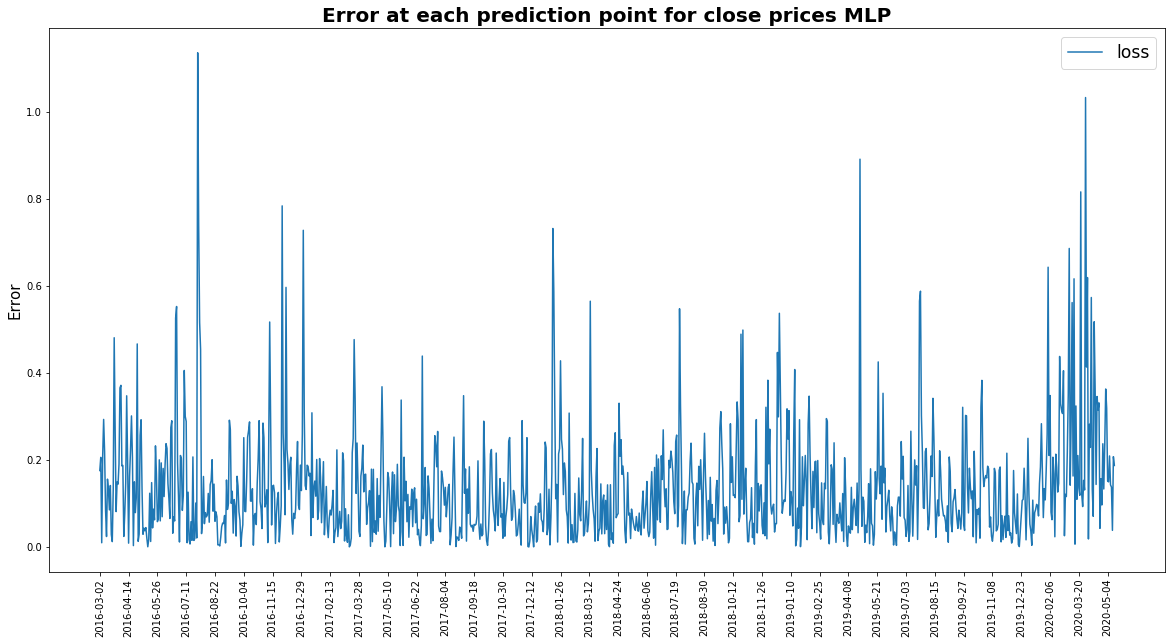

In [58]:

def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

title_str ='Error at each prediction point for high prices MLP'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)
title_str ='Error at each prediction point for low prices MLP'
mae(predicted_low,actual_low,np.array(predicted_dates),title_str)
title_str ='Error at each prediction point for close prices MLP'
mae(predicted_close,actual_close,np.array(predicted_dates),title_str)

<BarContainer object of 13 artists>

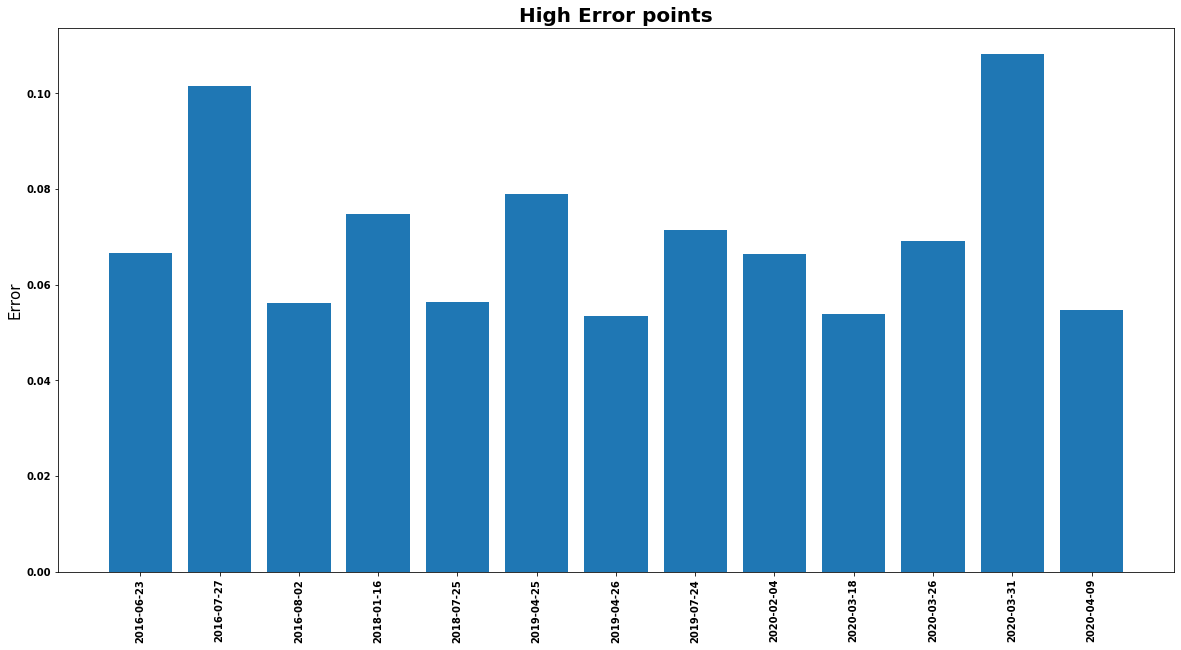

In [61]:

    large_loss = []
    large_loss_date = []
    for index in range(0,len(model_val_loss)):
        val_loss = model_val_loss[index]
        if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
            large_loss.append(val_loss)
            large_loss_date.append(predicted_dates[index])


    plt.rcParams["font.weight"] = "bold"
    plt.figure(figsize=(20,10))
    plt.title('High Error points',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    idx = np.arange(len(large_loss_date))
    plt.xticks(idx,large_loss_date,rotation=90)
    plt.bar(idx, large_loss, align='center', alpha=1)